In [33]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

PDE:
$$
u_t=u_{xx},\quad0\le x\le2\pi
$$
Boundary Conditions:
$$
u(0,t)=u(2\pi,t)=0
$$
Initial Condition:
$$
u(x,0)=\sin(mx)
$$
Exact Solution:
$$
u=\sin(mx)\exp(-m^2t)
$$

In [34]:
def forward_sweep(A,b):
    A_prime=deepcopy(A)
    b_prime=deepcopy(b)
    A_prime[0]/=A[0,0]
    b_prime[0]/=A[0,0]
    for i in range(1,A.shape[0]):
        b_prime[i]=(b_prime[i]-A_prime[i,i-1]/A_prime[i-1,i-1]*b_prime[i-1])/(A_prime[i,i]-A_prime[i,i-1]/A_prime[i-1,i-1]*A_prime[i-1,i])
        
        A_prime[i]=(A_prime[i]-A_prime[i,i-1]/A_prime[i-1,i-1]*A_prime[i-1])/(A_prime[i,i]-A_prime[i,i-1]/A_prime[i-1,i-1]*A_prime[i-1,i])
    
    return A_prime,b_prime
def solve_tridiagonal(A,b):
    A_prime,b_prime=forward_sweep(A,b)
    x=np.zeros_like(b)
    x[-1]=b_prime[-1]
    for i in reversed(range(b.shape[0]-1)):
        x[i]=b_prime[i]-A_prime[i,i+1]*x[i+1]
    return x

In [35]:
def forward_euler(max_t,m,r=None,delta_x=None,delta_t=None):
    if delta_t is None:
        delta_t=r*delta_x**2
    if delta_x is None:
        delta_x=np.sqrt(delta_t/r)
    if r is None:
        r=delta_t/delta_x**2
    grid=np.array(np.meshgrid(np.arange(0,2*np.pi+delta_x/2,delta_x),np.arange(0,max_t+delta_t/2,delta_t)))
    u=np.zeros((1,grid.shape[1],grid.shape[2])) #time space
    u[:,0,:]=np.sin(m * grid[0,0]) #initial condition
    u[:,:,0]=0 #boundary condition
    u[:,:,-1]=0 #boundary condition
    for n in range(u.shape[1]-1): #time
        for j in range(1,u.shape[2]-1): #space
            u[:,n+1,j]=r*(u[:,n,j+1]-2*u[:,n,j]+u[:,n,j-1])+u[:,n,j]
    return u,grid

In [36]:
def backward_euler(max_t,m,r=None,delta_x=None,delta_t=None):
    if delta_t is None:
        delta_t=r*delta_x**2
    if delta_x is None:
        delta_x=np.sqrt(delta_t/r)
    if r is None:
        r=delta_t/delta_x**2
    grid=np.array(np.meshgrid(np.arange(0,2*np.pi+delta_x/2,delta_x),np.arange(0,max_t+delta_t/2,delta_t)))
    u=np.zeros((1,grid.shape[1],grid.shape[2])) #time space
    
    u[:,0,:]=np.sin(m * grid[0,0]) #initial condition
    u[:,:,0]=0 #boundary condition
    u[:,:,-1]=0 #boundary condition
    
    A=np.zeros((u.shape[2]-2,u.shape[2]-2))
    np.fill_diagonal(A,1+2*r)
    np.fill_diagonal(A[1:],-r)
    np.fill_diagonal(A[:,1:],-r)

    for n in range(u.shape[1]-1): #time
        b=u[:,n,1:-1].T
        u[:,n+1,1:-1]=solve_tridiagonal(A,b).T
    return u,grid

In [37]:
def crank_nicolson(max_t,m,r=None,delta_x=None,delta_t=None):
    if delta_t is None:
        delta_t=r*delta_x**2
    if delta_x is None:
        delta_x=np.sqrt(delta_t/r)
    if r is None:
        r=delta_t/delta_x**2
    
    grid=np.array(np.meshgrid(np.arange(0,2*np.pi+delta_x/2,delta_x),np.arange(0,max_t+delta_t/2,delta_t)))
    
    u=np.zeros((1,grid.shape[1],grid.shape[2])) #time space
    u[:,0,:]=np.sin(m * grid[0,0]) #initial condition
    u[:,:,0]=0 #boundary condition
    u[:,:,-1]=0 #boundary condition
    
    A=np.zeros((u.shape[2]-2,u.shape[2]-2))
    np.fill_diagonal(A,2+2*r)
    np.fill_diagonal(A[1:],-r)
    np.fill_diagonal(A[:,1:],-r)
    
    B=np.zeros((u.shape[2]-2,u.shape[2]-2))
    np.fill_diagonal(B,2-2*r)
    np.fill_diagonal(B[1:],r)
    np.fill_diagonal(B[:,1:],r)

    for n in range(u.shape[1]-1): #time
        b=B @ u[:,n,1:-1].T
        u[:,n+1,1:-1]=solve_tridiagonal(A,b).T
    return u,grid

In [38]:
fe_solution,grid=forward_euler(delta_x=2*np.pi/20,max_t=2,r=1/3,m=2)
be_solution,grid=backward_euler(delta_x=2*np.pi/20,max_t=2,r=1/3,m=2)
cn_solution,grid=crank_nicolson(delta_x=2*np.pi/20,max_t=2,r=1/3,m=2)
print(grid.shape) #(x t) time space

(2, 62, 21)


In [39]:
def exact_solution(grid,m):
    u=np.zeros((1,grid.shape[1],grid.shape[2]))
    for i in range(u.shape[1]):
        u[:,i,:]=np.exp(-m**2 * grid[1,i]) * np.sin(m * grid[0,i])
    return u

In [40]:
solution = exact_solution(grid, 2)

In [41]:
t_01_ind=np.argmin(np.abs(grid[1,:,0]-0.1))
t_05_ind=np.argmin(np.abs(grid[1,:,0]-0.5))
t_1_ind=np.argmin(np.abs(grid[1,:,0]-1))
t_01_ind,t_05_ind,t_1_ind,grid[1,:,0]

(np.int64(3),
 np.int64(15),
 np.int64(30),
 array([0.        , 0.03289868, 0.06579736, 0.09869604, 0.13159473,
        0.16449341, 0.19739209, 0.23029077, 0.26318945, 0.29608813,
        0.32898681, 0.36188549, 0.39478418, 0.42768286, 0.46058154,
        0.49348022, 0.5263789 , 0.55927758, 0.59217626, 0.62507495,
        0.65797363, 0.69087231, 0.72377099, 0.75666967, 0.78956835,
        0.82246703, 0.85536571, 0.8882644 , 0.92116308, 0.95406176,
        0.98696044, 1.01985912, 1.0527578 , 1.08565648, 1.11855517,
        1.15145385, 1.18435253, 1.21725121, 1.25014989, 1.28304857,
        1.31594725, 1.34884593, 1.38174462, 1.4146433 , 1.44754198,
        1.48044066, 1.51333934, 1.54623802, 1.5791367 , 1.61203539,
        1.64493407, 1.67783275, 1.71073143, 1.74363011, 1.77652879,
        1.80942747, 1.84232615, 1.87522484, 1.90812352, 1.9410222 ,
        1.97392088, 2.00681956]))

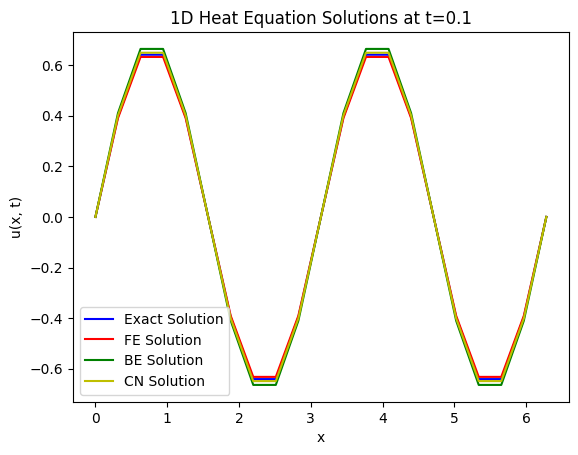

In [42]:
plt.plot(grid[0,t_01_ind], solution[0,t_01_ind], label='Exact Solution',c='b')
plt.plot(grid[0,t_01_ind], fe_solution[0,t_01_ind], label='FE Solution',c='r')
plt.plot(grid[0,t_01_ind], be_solution[0,t_01_ind], label='BE Solution',c='g')
plt.plot(grid[0,t_01_ind], cn_solution[0,t_01_ind], label='CN Solution',c='y')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('1D Heat Equation Solutions at t=0.1')
plt.legend(loc='lower left')
plt.show()

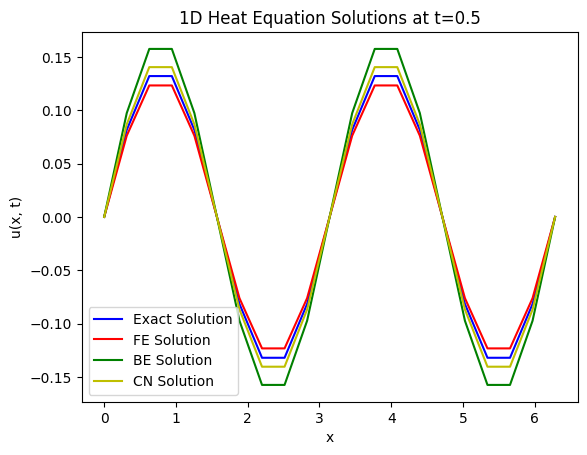

In [43]:
plt.plot(grid[0,t_05_ind], solution[0,t_05_ind], label='Exact Solution',c='b')
plt.plot(grid[0,t_05_ind], fe_solution[0,t_05_ind], label='FE Solution',c='r')
plt.plot(grid[0,t_05_ind], be_solution[0,t_05_ind], label='BE Solution',c='g')
plt.plot(grid[0,t_05_ind], cn_solution[0,t_05_ind], label='CN Solution',c='y')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('1D Heat Equation Solutions at t=0.5')
plt.legend(loc='lower left')
plt.show()

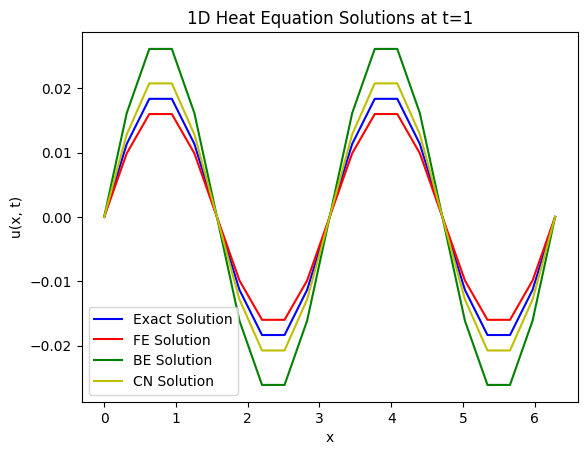

In [44]:
plt.plot(grid[0,t_1_ind], solution[0,t_1_ind], label='Exact Solution',c='b')
plt.plot(grid[0,t_1_ind], fe_solution[0,t_1_ind], label='FE Solution',c='r')
plt.plot(grid[0,t_1_ind], be_solution[0,t_1_ind], label='BE Solution',c='g')
plt.plot(grid[0,t_1_ind], cn_solution[0,t_1_ind], label='CN Solution',c='y')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('1D Heat Equation Solutions at t=1')
plt.legend(loc='lower left')
plt.show()